## 데이터 및 환경설정

### 1) 필요한 라이브러리 설치

In [1]:
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from transformers import EarlyStoppingCallback

import wandb

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'../NanumBarunGothic.ttf',
    name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})
plt.rc('font', family='NanumBarunGothic')

In [76]:
from konlpy.tag import Okt
from konlpy.tag import Kkma
from konlpy.tag import Hannanum
from konlpy.tag import Komoran

from collections import Counter
from wordcloud import WordCloud

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: developzest (developzest_org). Use `wandb login --relogin` to force relogin


True

In [4]:
# 상수 정의
DATA_DIR = '../data/'
OUTPUT_DIR = '../output/'
CONFIG_DIR = '../config/'

MODEL_NAME = "digit82/kobart-summarization"

WANDB_USER_NAME = 'developzest_org'
WANDB_PROJECT_NAME = 'nlp_dialog_summary'
WANDB_RUN_NAME = 'baseline_addEvalMode'

### 2) Config file 만들기 (선택)
- 모델 생성에 필요한 다양한 매개변수 정보를 독립적인 매개변수 정보 파일을 생성하여 관리

In [5]:
# config 설정에 tokenizer 모듈이 사용되므로 미리 tokenizer를 정의해줍니다.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [80]:

config_data = {
    "general": {
        "data_path": DATA_DIR, # 모델 생성에 필요한 데이터 경로를 사용자 환경에 맞게 지정합니다.
        "model_name": MODEL_NAME, # 불러올 모델의 이름을 사용자 환경에 맞게 지정할 수 있습니다.
        "output_dir": OUTPUT_DIR # 모델의 최종 출력 값을 저장할 경로를 설정합니다.
    },
    "tokenizer": {
        "encoder_max_len": 512,
        "decoder_max_len": 100,
        "bos_token": f"{tokenizer.bos_token}",
        "eos_token": f"{tokenizer.eos_token}",
        # 특정 단어들이 분해되어 tokenization이 수행되지 않도록 special_tokens을 지정해줍니다.
        "special_tokens": ['#Person1#', '#Person2#', '#Person3#', '#Person4#', '#Person5#', '#Person6#', '#Person7#',
                           '#PhoneNumber#', '#Address#', '#DateOfBirth#', '#PassportNumber#',
                           '#SSN#', '#CardNumber#', '#CarNumber#', '#Email#']
    },
    "training": {
        "overwrite_output_dir": True,
        "num_train_epochs": 20,
        "learning_rate": 1e-5,
        "per_device_train_batch_size": 50,
        "per_device_eval_batch_size": 32,
        "warmup_ratio": 0.1,
        "weight_decay": 0.01,
        "lr_scheduler_type": 'cosine',
        "optim": 'adamw_torch',
        "gradient_accumulation_steps": 1,
        "evaluation_strategy": 'epoch',
        "save_strategy": 'epoch',
        "save_total_limit": 5,
        "fp16": True,
        "load_best_model_at_end": True,
        "seed": 42,
        "logging_dir": "./logs",
        "logging_strategy": "epoch",
        "predict_with_generate": True,
        "generation_max_length": 100,
        "do_train": True,
        "do_eval": True,
        "early_stopping_patience": 3,
        "early_stopping_threshold": 0.001,
        "report_to": "wandb" # (선택) wandb를 사용할 때 설정합니다.
    },
    # (선택) wandb 홈페이지에 가입하여 얻은 정보를 기반으로 작성합니다.
    "wandb": {
        "entity": WANDB_USER_NAME,
        "project": WANDB_PROJECT_NAME,
        "name": WANDB_RUN_NAME
    },
    "inference": {
        "ckt_path": "model ckt path", # 사전 학습이 진행된 모델의 checkpoint를 저장할 경로를 설정합니다.
        "result_path": "./prediction/",
        # "no_repeat_ngram_size": 2,
        'repetition_penalty': 1.2,
        "early_stopping": True,
        "generate_max_length": 100,
        "num_beams": 4,
        "batch_size" : 32,
        # "length_penalty": 0.25,
        # 정확한 모델 평가를 위해 제거할 불필요한 생성 토큰들을 정의합니다.
        "remove_tokens": ['<usr>', f"{tokenizer.bos_token}", f"{tokenizer.eos_token}", f"{tokenizer.pad_token}"]
    }
}

- 참고✅    
: wandb 라이브러리를 사용하기 위해선 entity, project, name를 지정해주어야 합니다. wandb 홈페이지에 가입한 후 얻은 정보를 입력하여 작동할 수 있습니다.

In [81]:
# 모델의 구성 정보를 YAML 파일로 저장합니다.
config_path = f"{CONFIG_DIR}config.yaml"
with open(config_path, "w") as file:
    yaml.dump(config_data, file, allow_unicode=True)

### 3) Configuration 불러오기

In [6]:
# 저장된 config 파일을 불러옵니다.
config_path = f"{CONFIG_DIR}config_baselineAdditionalSpecialToken.yaml"

with open(config_path, "r") as file:
    loaded_config = yaml.safe_load(file)

# 불러온 config 파일의 전체 내용을 확인합니다.
pprint(loaded_config)

{'general': {'data_path': '../data/',
             'model_name': 'digit82/kobart-summarization',
             'output_dir': '../output/'},
 'inference': {'batch_size': 32,
               'ckt_path': 'model ckt path',
               'early_stopping': True,
               'generate_max_length': 100,
               'no_repeat_ngram_size': 2,
               'num_beams': 4,
               'remove_tokens': ['<usr>', '<s>', '</s>', '<pad>'],
               'result_path': './prediction/'},
 'tokenizer': {'bos_token': '<s>',
               'decoder_max_len': 100,
               'encoder_max_len': 512,
               'eos_token': '</s>',
               'special_tokens': ['#Person1#',
                                  '#Person2#',
                                  '#Person3#',
                                  '#Person4#',
                                  '#Person5#',
                                  '#Person6#',
                                  '#Person7#',
                                  '

In [47]:
# 실험에 쓰일 데이터의 경로, 사용될 모델, 모델의 최종 출력 결과를 저장할 경로에 대해 확인합니다.
loaded_config['general']

{'data_path': '../data/',
 'model_name': 'digit82/kobart-summarization',
 'output_dir': '../output/'}

In [ ]:
# 이곳에 사용자가 저장한 데이터 dir 설정하기
# loaded_config['general']['data_path'] = DATA_DIR

In [48]:
# 데이터 전처리를 하기 위해 tokenization 과정에서 필요한 정보들을 확인합니다.
loaded_config['tokenizer']

{'bos_token': '<s>',
 'decoder_max_len': 100,
 'encoder_max_len': 512,
 'eos_token': '</s>',
 'special_tokens': ['#Person1#',
  '#Person2#',
  '#Person3#',
  '#Person4#',
  '#Person5#',
  '#Person6#',
  '#Person7#',
  '#PhoneNumber#',
  '#Address#',
  '#DateOfBirth#',
  '#PassportNumber#',
  '#SSN#',
  '#CardNumber#',
  '#CarNumber#',
  '#Email#']}

In [49]:
# 모델이 훈련 시 적용될 매개변수를 확인합니다.
loaded_config['training']

{'do_eval': True,
 'do_train': True,
 'early_stopping_patience': 3,
 'early_stopping_threshold': 0.001,
 'evaluation_strategy': 'epoch',
 'fp16': True,
 'generation_max_length': 100,
 'gradient_accumulation_steps': 1,
 'learning_rate': 1e-05,
 'load_best_model_at_end': True,
 'logging_dir': './logs',
 'logging_strategy': 'epoch',
 'lr_scheduler_type': 'cosine',
 'num_train_epochs': 20,
 'optim': 'adamw_torch',
 'overwrite_output_dir': True,
 'per_device_eval_batch_size': 32,
 'per_device_train_batch_size': 50,
 'predict_with_generate': True,
 'report_to': 'wandb',
 'save_strategy': 'epoch',
 'save_total_limit': 5,
 'seed': 42,
 'warmup_ratio': 0.1,
 'weight_decay': 0.01}

In [8]:
# 모델 학습 과정에 대한 정보를 제공해주는 wandb 설정 내용을 확인합니다.
loaded_config['wandb']

{'entity': 'developzest_org',
 'name': 'baseline_addEvalMode',
 'project': 'nlp_dialog_summary'}

In [7]:
# (선택) 이곳에 사용자가 사용할 wandb config 설정
# loaded_config['wandb']['entity'] = WANDB_USER_NAME #사용할 wandb repo name
# loaded_config['wandb']['name'] = WANDB_RUN_NAME #사용할 wandb run의 name
# loaded_config['wandb']['project'] = WANDB_PROJECT_NAME #사용할 wandb project name

In [83]:
# 모델이 최종 결과를 출력하기 위한 매개변수 정보를 확인합니다.
loaded_config['inference']

{'batch_size': 32,
 'ckt_path': 'model ckt path',
 'early_stopping': True,
 'generate_max_length': 100,
 'num_beams': 4,
 'remove_tokens': ['<usr>', '<s>', '</s>', '<pad>'],
 'repetition_penalty': 1.2,
 'result_path': './prediction/'}

### 4) 데이터 불러와서 확인해보기
- 실험에서 쓰일 데이터를 load하여 데이터의 구조와 내용을 살펴보겠습니다.
- Train, dev, test 순서대로 12457, 499, 250개 씩 데이터가 구성되어 있습니다.

In [9]:
# config에 저장된 데이터 경로를 통해 train과 validation data를 불러옵니다.
data_path = loaded_config['general']['data_path']

# train data의 구조와 내용을 확인합니다.
train_df = pd.read_csv(os.path.join(data_path,'train.csv'))
train_df.tail()

,fname,dialogue,summary,topic
12452,train_12455,#Person1#: 실례합니다. 맨체스터 출신의 그린 씨이신가요?\n#Person2...,탄 링은 흰머리와 수염으로 쉽게 인식되는 그린 씨를 만나 호텔로 데려갈 예정입니다....,누군가를 태우다
12453,train_12456,#Person1#: 이윙 씨가 우리가 컨퍼런스 센터에 오후 4시에 도착해야 한다고 ...,#Person1#과 #Person2#는 이윙 씨가 늦지 않도록 요청했기 때문에 컨퍼...,컨퍼런스 센터
12454,train_12457,#Person1#: 오늘 어떻게 도와드릴까요?\n#Person2#: 차를 빌리고 싶...,#Person2#는 #Person1#의 도움으로 5일 동안 소형 차를 빌립니다.,차 렌트
12455,train_12458,#Person1#: 오늘 좀 행복해 보이지 않아. 무슨 일 있어?\n#Person2...,#Person2#의 엄마가 일자리를 잃었다. #Person2#는 엄마가 우울해하지 ...,실직
12456,train_12459,"#Person1#: 엄마, 다음 토요일에 이 삼촌네 가족을 방문하기 위해 비행기를 ...",#Person1#은 다음 토요일에 이 삼촌네를 방문할 때 가방을 어떻게 싸야 할지 ...,짐 싸기


In [10]:
# validation data의 구조와 내용을 확인합니다.
val_df = pd.read_csv(os.path.join(data_path,'dev.csv'))
val_df.tail()

,fname,dialogue,summary,topic
494,dev_495,#Person1#: 이제 새해가 되어서 새로운 시작을 하려고 결심했어. \r\n#P...,#Person1#은 새해에 금연을 하고 커밍아웃하기로 결정했습니다. #Person2...,새해
495,dev_496,"#Person1#: 너, 조랑 결혼했지? \r\n#Person2#: 조? 무슨 말인...",#Person1#은 #Person2#가 조와 결혼했다고 생각했다. #Person2#...,사랑에 빠지다
496,dev_497,"#Person1#: 무엇을 도와드릴까요, 부인?\r\n#Person2#: 몇 주 동...",#Person2#의 차에서 이상한 소리가 납니다. #Person1#는 브레이크를 교...,소음
497,dev_498,"#Person1#: 안녕하세요, 아마존 고객 서비스입니다. 무엇을 도와드릴까요?\n...",#Person2#님이 아마존 고객 서비스에 전화하여 아마존에서 받은 책에 한 페이지...,빠진 페이지
498,dev_499,#Person1#: 여름이 다 되어간다는 게 믿기지 않아.\r\n#Person2#:...,#Person2#는 #Person1#에게 여름 휴가 동안 파티를 도와주는 회사에서 ...,여름 휴가


In [11]:
# test data의 구조와 내용을 확인합니다.
test_df = pd.read_csv(os.path.join(data_path,'test.csv'))
test_df.tail()

,fname,dialogue
494,test_495,"#Person1#: 헤이, 찰리, 학교 끝나고 우리 집에 와서 나랑 비디오 게임 할..."
495,test_496,#Person1#: 어떻게 컨트리 음악에 관심을 가지게 되었나요?\r\n#Perso...
496,test_497,"#Person1#: 실례합니다, 앨리스. 이곳을 사용해본 적이 없는데, 기계를 어떻..."
497,test_498,#Person1#: 매튜? 안녕!\r\n#Person2#: 스티브! 오랜만이네! 얼...
498,test_499,"#Person1#: 헤이, 벳시, 좋은 소식 들었어?\n#Person2#: 아니, ..."


#### 4-1) EDA

##### [TODO] - 대화 / 요약문의 max_length 선택

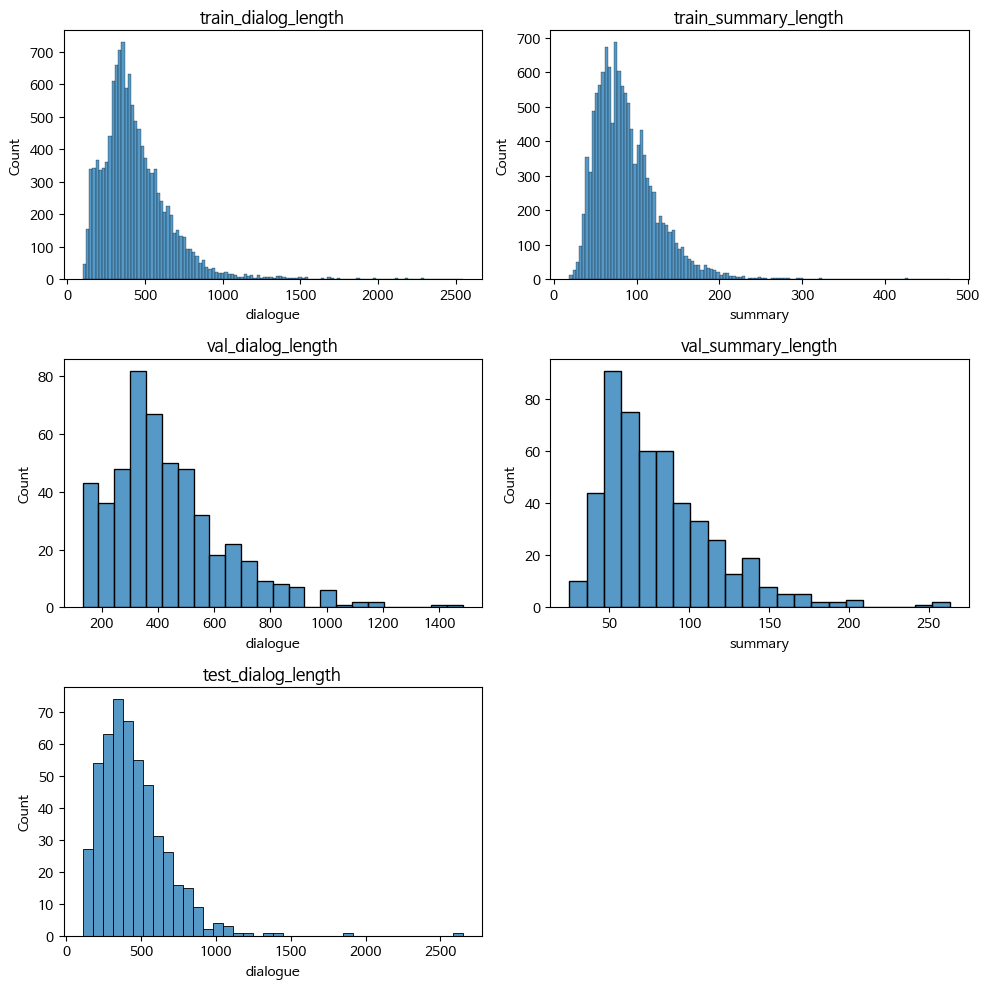

train_dialog_length
count    12457.000000
mean       438.765112
std        220.134710
min         99.000000
25%        299.000000
50%        396.000000
75%        540.000000
max       2546.000000
Name: dialogue, dtype: float64
train_summary_length
count    12457.000000
mean        87.397929
std         37.641178
min         19.000000
25%         61.000000
50%         80.000000
75%        106.000000
max        478.000000
Name: summary, dtype: float64
val_dialog_length
count     499.000000
mean      432.559118
std       206.074045
min       132.000000
25%       299.000000
50%       392.000000
75%       526.000000
max      1484.000000
Name: dialogue, dtype: float64
val_summary_length
count    499.000000
mean      81.709419
std       35.877381
min       25.000000
25%       55.000000
50%       74.000000
75%       98.000000
max      263.000000
Name: summary, dtype: float64
test_dialog_length
count     499.000000
mean      449.312625
std       239.192203
min       109.000000
25%       289.000

In [35]:
# max_length 확인
train_dialog_length = train_df['dialogue'].apply(lambda x: len(x))
train_summary_length = train_df['summary'].apply(lambda x: len(x))

val_dialog_length = val_df['dialogue'].apply(lambda x: len(x))
val_summary_length = val_df['summary'].apply(lambda x: len(x))

test_dialog_length = test_df['dialogue'].apply(lambda x: len(x))

# histplot으로 시각화
fig = plt.figure(figsize=(10, 10))
ax_td = fig.add_subplot(3, 2, 1)
ax_ts = fig.add_subplot(3, 2, 2)
ax_vd = fig.add_subplot(3, 2, 3)
ax_vs = fig.add_subplot(3, 2, 4)
ax_ted = fig.add_subplot(3, 2, 5)

ax_td.set_title("train_dialog_length")
ax_ts.set_title("train_summary_length")
ax_vd.set_title("val_dialog_length")
ax_vs.set_title("val_summary_length")
ax_ted.set_title("test_dialog_length")

sns.histplot(data=train_dialog_length, ax=ax_td)
sns.histplot(data=train_summary_length, ax=ax_ts)
sns.histplot(data=val_dialog_length, ax=ax_vd)
sns.histplot(data=val_summary_length, ax=ax_vs)
sns.histplot(data=test_dialog_length, ax=ax_ted)

plt.tight_layout()
plt.show()

# 요약 정보 출력
print("train_dialog_length")
print(train_dialog_length.describe())
print("train_summary_length")
print(train_summary_length.describe())
print("=================")
print("val_dialog_length")
print(val_dialog_length.describe())
print("val_summary_length")
print(val_summary_length.describe())
print("=================")
print("test_dialog_length")
print(test_dialog_length.describe())
print("=================")

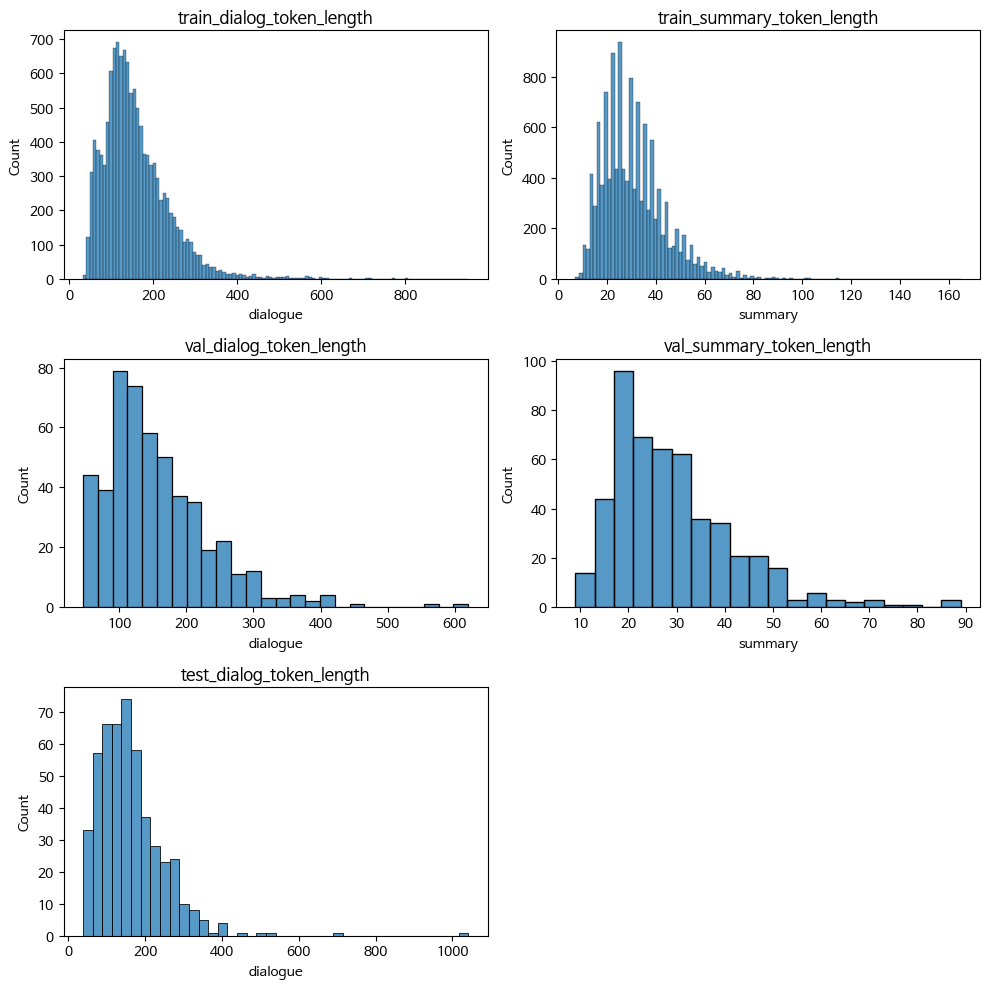

train_dialog_token_length
count    12457.000000
mean       158.597335
std         82.492587
min         32.000000
25%        105.000000
50%        141.000000
75%        197.000000
max        950.000000
Name: dialogue, dtype: float64
train_summary_token_length
count    12457.000000
mean        30.980734
std         13.636950
min          7.000000
25%         21.000000
50%         29.000000
75%         38.000000
max        165.000000
Name: summary, dtype: float64
val_dialog_token_length
count    499.000000
mean     156.687375
std       78.526915
min       46.000000
25%      104.000000
50%      139.000000
75%      194.000000
max      620.000000
Name: dialogue, dtype: float64
val_summary_token_length
count    499.000000
mean      28.795591
std       12.938467
min        9.000000
25%       19.000000
50%       26.000000
75%       35.000000
max       89.000000
Name: summary, dtype: float64
test_dialog_token_length
count     499.000000
mean      163.146293
std        90.632719
min        38.00

In [36]:
temp_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
special_tokens_dict={'additional_special_tokens':loaded_config['tokenizer']['special_tokens']}
temp_tokenizer.add_special_tokens(special_tokens_dict)

train_dialog_token_length = train_df['dialogue'].apply(lambda x: len(temp_tokenizer.tokenize(x)))
train_summary_token_length = train_df['summary'].apply(lambda x: len(temp_tokenizer.tokenize(x)))

val_dialog_token_length = val_df['dialogue'].apply(lambda x: len(temp_tokenizer.tokenize(x)))
val_summary_token_length = val_df['summary'].apply(lambda x: len(temp_tokenizer.tokenize(x)))

test_dialog_token_length = test_df['dialogue'].apply(lambda x: len(temp_tokenizer.tokenize(x)))

# histplot으로 시각화
fig = plt.figure(figsize=(10, 10))
ax_td = fig.add_subplot(3, 2, 1)
ax_ts = fig.add_subplot(3, 2, 2)
ax_vd = fig.add_subplot(3, 2, 3)
ax_vs = fig.add_subplot(3, 2, 4)
ax_ted = fig.add_subplot(3, 2, 5)

ax_td.set_title("train_dialog_token_length")
ax_ts.set_title("train_summary_token_length")
ax_vd.set_title("val_dialog_token_length")
ax_vs.set_title("val_summary_token_length")
ax_ted.set_title("test_dialog_token_length")

sns.histplot(data=train_dialog_token_length, ax=ax_td)
sns.histplot(data=train_summary_token_length, ax=ax_ts)
sns.histplot(data=val_dialog_token_length, ax=ax_vd)
sns.histplot(data=val_summary_token_length, ax=ax_vs)
sns.histplot(data=test_dialog_token_length, ax=ax_ted)

plt.tight_layout()
plt.show()

# 요약 정보 출력
print("train_dialog_token_length")
print(train_dialog_token_length.describe())
print("train_summary_token_length")
print(train_summary_token_length.describe())
print("=================")
print("val_dialog_token_length")
print(val_dialog_token_length.describe())
print("val_summary_token_length")
print(val_summary_token_length.describe())
print("=================")
print("test_dialog_token_length")
print(test_dialog_token_length.describe())
print("=================")

##### [TODO] - topic이 따로 쓰이는 곳이 없는데 전처리하여 이용하는 방법 고려

In [28]:
# topic 갯수
print('train topic nunique:', train_df['topic'].nunique())
print('val topic nunique:', val_df['topic'].nunique())

train_value_counts_df = train_df['topic'].value_counts().reset_index()
val_value_counts_df = val_df['topic'].value_counts().reset_index()

train topic nunique: 6526
val topic nunique: 446


In [26]:
train_value_counts_df

,topic,count
0,일상 대화,236
1,쇼핑,188
2,전화 통화,98
3,직업 면접,92
4,음식 주문,85
...,...,...
6521,빵 쇼핑,1
6522,착각,1
6523,기업 운영,1
6524,밴드,1


In [27]:
val_value_counts_df

,topic,count
0,직업 면접,9
1,쇼핑,7
2,레스토랑에서,4
3,일상 대화,4
4,운동하기,3
...,...,...
441,스카이다이빙,1
442,교재 구매,1
443,음악 연주,1
444,나노미터의 설명,1


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8 ) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


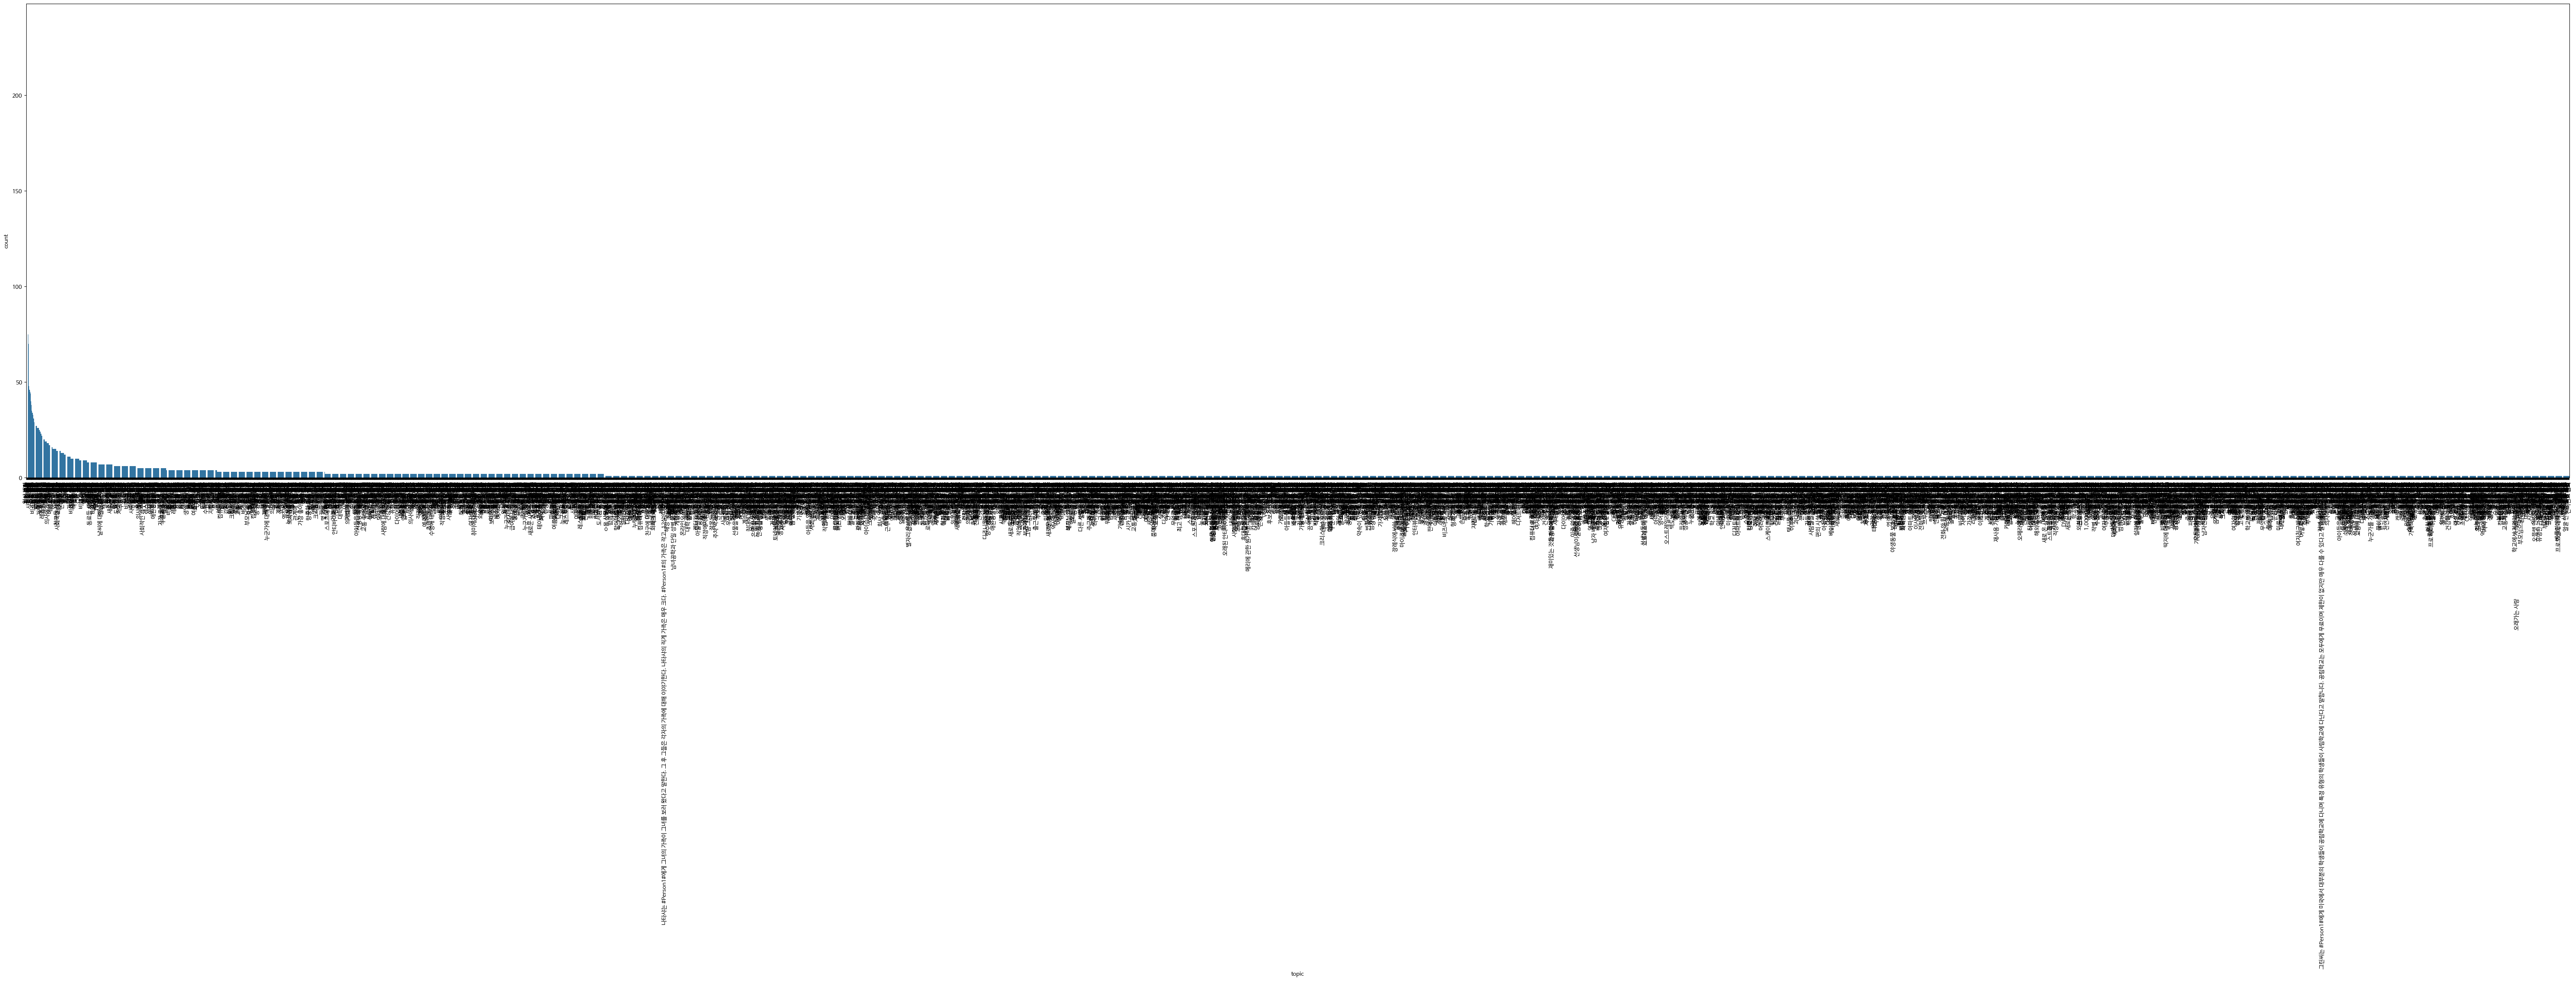

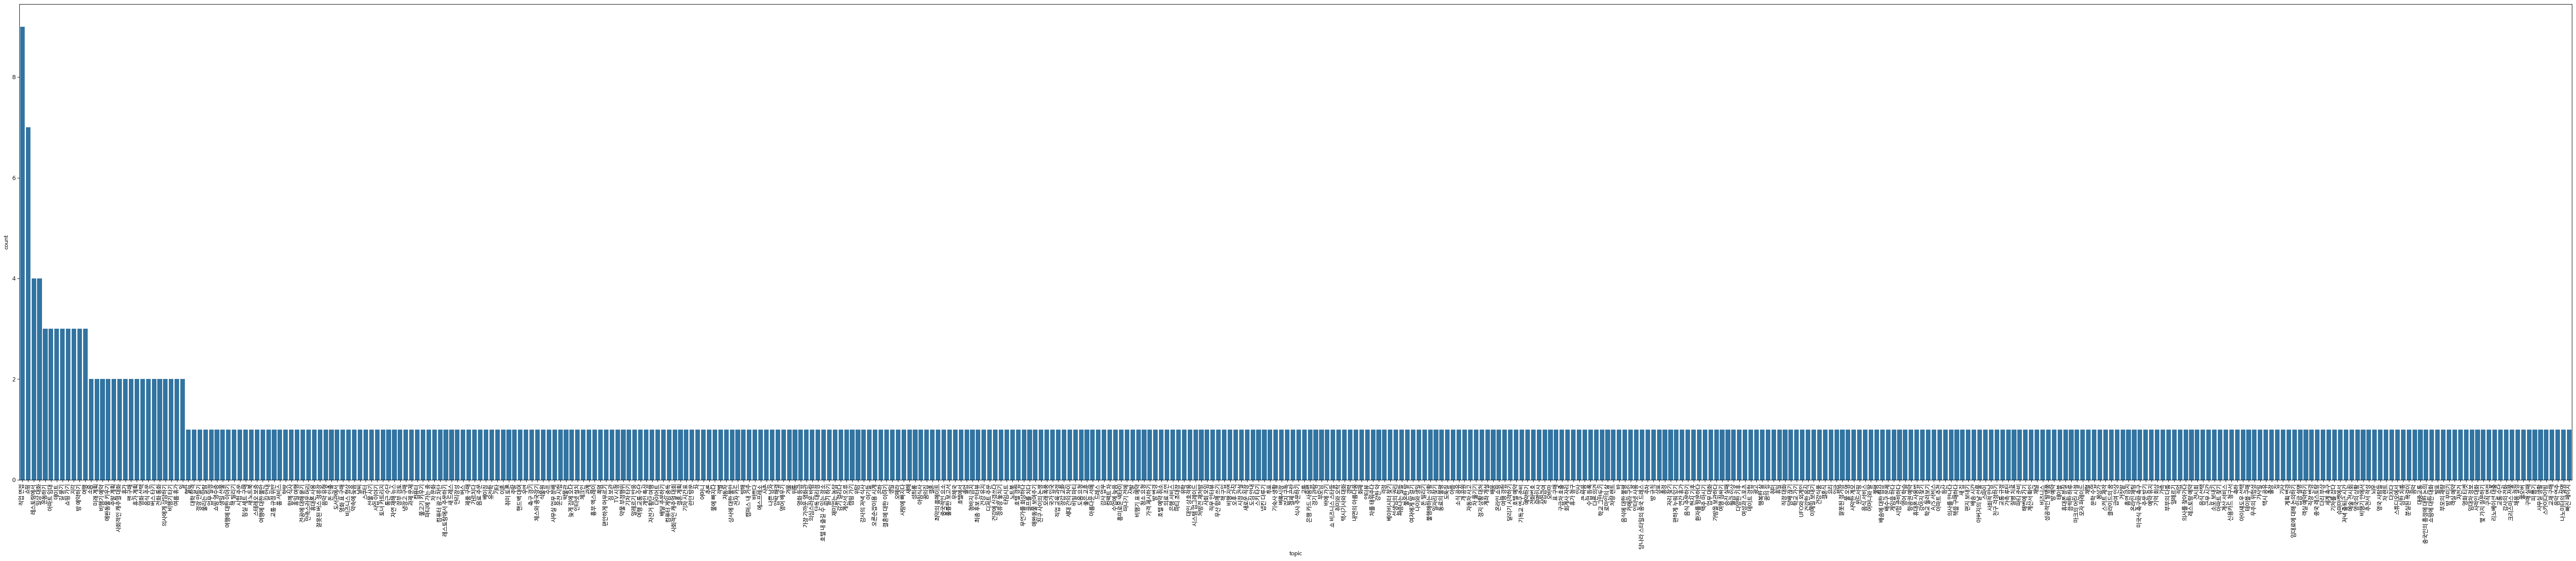

In [29]:
# topic 시각화
plt.figure(figsize=(80, 15))
sns.barplot(data=train_value_counts_df, x='topic', y='count')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(80, 15))
sns.barplot(data=val_value_counts_df, x='topic', y='count')
plt.xticks(rotation=90)
plt.show()

In [47]:
# 75% 이상이 topic count 1
pprint(train_value_counts_df['count'].describe())
pprint(val_value_counts_df['count'].describe())

count    6526.000000
mean        1.908826
std         5.228463
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       236.000000
Name: count, dtype: float64
count    446.000000
mean       1.118834
std        0.600939
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        9.000000
Name: count, dtype: float64


In [51]:
train_value_counts_df.loc[train_value_counts_df['count'] > 1]

,topic,count
0,일상 대화,236
1,쇼핑,188
2,전화 통화,98
3,직업 면접,92
4,음식 주문,85
...,...,...
1479,동물원 방문,2
1480,미용사,2
1481,집값,2
1482,체스 두기,2


In [49]:
val_value_counts_df.loc[val_value_counts_df['count'] > 1]

,topic,count
0,직업 면접,9
1,쇼핑,7
2,레스토랑에서,4
3,일상 대화,4
4,운동하기,3
5,아파트 임대,3
6,데이트,3
7,길 묻기,3
8,쇼핑 가기,3
9,지각,3


#### 4-2) 텍스트 데이터 전처리

In [12]:
# 자/모음으로만 구성된 경우 존재 여부 확인
print('[train] 자음으로만 구성된 갯수:', train_df.loc[train_df['dialogue'].apply(lambda x: len(re.findall('[ㄱ-ㅎ|ㅏ-ㅣ]', x))) > 0, 'dialogue'].count())
print('[val] 자음으로만 구성된 갯수:', val_df.loc[val_df['dialogue'].apply(lambda x: len(re.findall('[ㄱ-ㅎ|ㅏ-ㅣ]', x))) > 0, 'dialogue'].count())
print('[test] 자음으로만 구성된 갯수:', test_df.loc[test_df['dialogue'].apply(lambda x: len(re.findall('[ㄱ-ㅎ|ㅏ-ㅣ]', x))) > 0, 'dialogue'].count())

# 자/모음으로만 구성된 문자 -> '' 로 변환
train_df['dialogue'] = train_df['dialogue'].apply(lambda x: re.sub('[ㄱ-ㅎ|ㅏ-ㅣ]', '', x))
print('[train] 자음으로만 구성된 경우 제거한 갯수:', train_df.loc[train_df['dialogue'].apply(lambda x: len(re.findall('[ㄱ-ㅎ|ㅏ-ㅣ]', x))) > 0, 'dialogue'].count())

[train] 자음으로만 구성된 갯수: 7
[val] 자음으로만 구성된 갯수: 0
[test] 자음으로만 구성된 갯수: 0
[train] 자음으로만 구성된 경우 제거한 갯수: 0


#### 4-3) 위드클라우드 활용한 주요 대화 주제 확인

In [13]:
kkma = Kkma()
okt = Okt()
komoran = Komoran()
hannanum = Hannanum()

print('okt 형태소 분석 결과 ==>', okt.morphs(train_df['dialogue'].iloc[0]))
print('='*20)
print('kkma 형태소 분석 결과 ==>', kkma.morphs(train_df['dialogue'].iloc[0]))
print('='*20)
print('komoran 형태소 분석 결과 ==>', komoran.morphs(train_df['dialogue'].iloc[0]))
print('='*20)
print('hannanum 형태소 분석 결과 ==>', hannanum.morphs(train_df['dialogue'].iloc[0]))
print('='*20)

print('okt 명사 추출 결과 ==>', okt.nouns(train_df['dialogue'].iloc[0]))
print('='*20)
print('kkma 명사 추출 결과 ==>', kkma.nouns(train_df['dialogue'].iloc[0]))
print('='*20)
print('komoran 명사 추출 결과 ==>', komoran.nouns(train_df['dialogue'].iloc[0]))
print('='*20)
print('hannanum 명사 추출 결과 ==>', hannanum.nouns(train_df['dialogue'].iloc[0]))
print('='*20)

okt 형태소 분석 결과 ==> ['#Person1', '#:', '안녕하세요', ',', '스미스', '씨', '.', '저', '는', '호킨스', '의사', '입니다', '.', '오늘', '왜', '오셨나요', '?', '\n', '#Person2', '#:', '건강검진', '을', '받는', '것', '이', '좋을', '것', '같아서요', '.', '\n', '#Person1', '#:', '그렇군요', ',', '당신', '은', '5년', '동안', '건강검진', '을', '받지', '않았습니다', '.', '매년', '받아야', '합니다', '.', '\n', '#Person2', '#:', '알', '고', '있습니다', '.', '하지만', '아무', '문제', '가', '없다면', '왜', '의사', '를', '만나러', '가야', '하나요', '?', '\n', '#Person1', '#:', '심각한', '질병', '을', '피하', '는', '가장', '좋은', '방법', '은', '이를', '조기', '에', '발견', '하는', '것', '입니다', '.', '그러니', '당신', '의', '건강', '을', '위해', '최소한', '매년', '한', '번은', '오세요', '.', '\n', '#Person2', '#:', '알겠습니다', '.', '\n', '#Person1', '#:', '여기', '보세요', '.', '당신', '의', '눈', '과', '귀', '는', '괜찮아', '보입니다', '.', '깊게', '숨', '을', '들이', '쉬세요', '.', '스미스', '씨', ',', '담배', '피우시나요', '?', '\n', '#Person2', '#:', '네', '.', '\n', '#Person1', '#:', '당신', '도', '알다시피', ',', '담배', '는', '폐암', '과', '심장병', '의', '주요', '원인', '입니다', '.', '정말로', '끊으셔야', '합니다', '.

In [15]:
def get_noun(tag, text):       
    noun = tag.nouns(text)    
    for i,v in enumerate(noun):        
        if len(v)<2:            
            noun.pop(i)    
    count = Counter(noun)    
    noun_list = count.most_common(100)    
    return noun_list

def visualize(noun_list, title):    # 워드클라우드 이미지 생성
    wc= WordCloud(        
        font_path = r'../NanumBarunGothic.ttf',    # 한글폰트 경로 설정
        background_color='white',                             # 배경 색깔 정하기
        colormap = 'Dark2',                                # 폰트 색깔 정하기
        width = 800,       
        height = 800).generate_from_frequencies(dict(noun_list))    
    plt.figure(figsize=(10,10)) #이미지 사이즈 지정
    plt.suptitle("Word Cloud", fontsize=40)    
    plt.title(title, fontsize=20)    
    plt.imshow(wc, interpolation='lanczos') #이미지의 부드럽기 정도
    plt.axis('off') #x y 축 숫자 제거
    plt.show()  # 워드클라우드 이미지 확인
    return wc

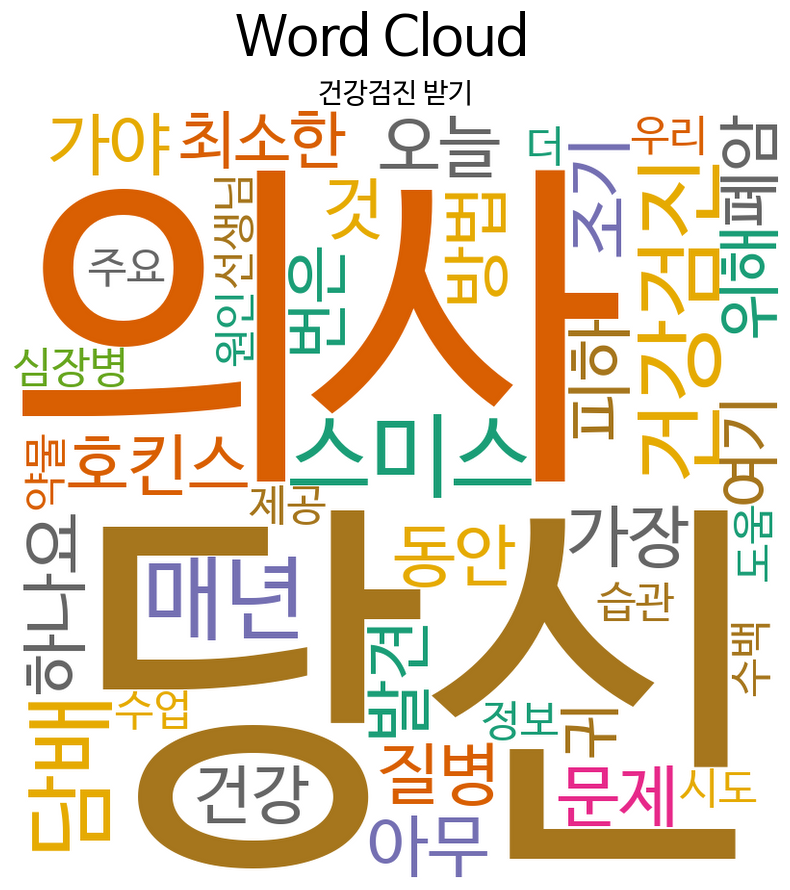

In [21]:
total_reviews = visualize(get_noun(okt, train_df['dialogue'].iloc[0]), train_df['topic'].iloc[0]) # 워드클라우드 시각화

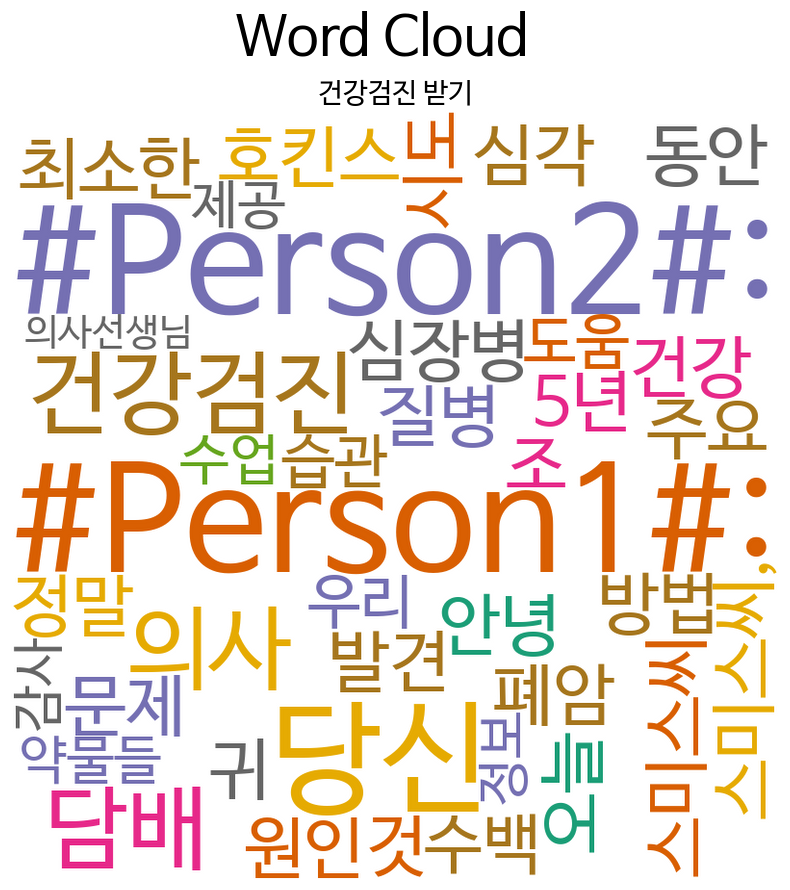

In [22]:
total_reviews = visualize(get_noun(hannanum, train_df['dialogue'].iloc[0]), train_df['topic'].iloc[0]) # 워드클라우드 시각화

##### [TODO] - TF-IDF

- (Term Frequency - Inverse Document Frequency)
- 어떤 단어가 특정 문서 내에서 얼마나 중요한 것인지를 나타내는 수치
- 여러 문서에서 공통적으로 자주 등장하는 단어보다는 특정 문서 내에서 더 중요하게 판단되는 단어를 추출해준다.

#### 4-4) 개인정보 마스킹 부분 확인

In [23]:
# 개인정보 마스킹 special token 추출
def reg_masking(text):  
    pattern = r"#\w+#"  # ## 사이의 값을 추출하는 정규식 패턴
    masked = re.findall(pattern, text)  
    return masked

train_set = train_df['dialogue'].apply(lambda x:str(set(reg_masking(x))))
val_set = val_df['dialogue'].apply(lambda x:str(set(reg_masking(x))))
test_set = test_df['dialogue'].apply(lambda x:str(set(reg_masking(x))))

In [52]:
train_set.sample(10)

3638                      {'#Person1#', '#Person2#'}
708                       {'#Person1#', '#Person2#'}
1785                      {'#Person1#', '#Person2#'}
10367                     {'#Person1#', '#Person2#'}
4068                      {'#Person1#', '#Person2#'}
859                       {'#Person1#', '#Person2#'}
9953                      {'#Person1#', '#Person2#'}
3182     {'#Person1#', '#PhoneNumber#', '#Person2#'}
1267                      {'#Person1#', '#Person2#'}
9094                      {'#Person1#', '#Person2#'}
Name: dialogue, dtype: object

In [35]:
val_set.sample(10)

165                     {'#Person1#', '#Person2#'}
13                      {'#Person1#', '#Person2#'}
74                      {'#Person1#', '#Person2#'}
277                     {'#Person1#', '#Person2#'}
91                      {'#Person1#', '#Person2#'}
60                      {'#Person1#', '#Person2#'}
302                     {'#Person1#', '#Person2#'}
467                     {'#Person1#', '#Person2#'}
136    {'#Person1#', '#Person2#', '#DateOfBirth#'}
419                     {'#Person1#', '#Person2#'}
Name: dialogue, dtype: object

In [50]:
test_set.sample(10)

269                 {'#Person1#', '#Person2#'}
215                 {'#Person1#', '#Person2#'}
424                 {'#Person1#', '#Person2#'}
19                  {'#Person1#', '#Person2#'}
176    {'#Person1#', '#Address#', '#Person2#'}
297                 {'#Person1#', '#Person2#'}
157                 {'#Person1#', '#Person2#'}
441                 {'#Person1#', '#Person2#'}
230                 {'#Person1#', '#Person2#'}
375                 {'#Person1#', '#Person2#'}
Name: dialogue, dtype: object

## 1. 데이터 가공 및 데이터셋 클래스 구축
- csv file 을 불러와서 encoder 와 decoder의 입력형태로 가공해줍니다.
- 가공된 데이터를 torch dataset class 로 구축하여 모델에 입력가능한 형태로 만듭니다.

In [13]:
# 데이터 전처리를 위한 클래스로, 데이터셋을 데이터프레임으로 변환하고 인코더와 디코더의 입력을 생성합니다.
class Preprocess:
    def __init__(self,
            bos_token: str,
            eos_token: str,
        ) -> None:

        self.bos_token = bos_token
        self.eos_token = eos_token

    @staticmethod
    # 실험에 필요한 컬럼을 가져옵니다.
    def make_set_as_df(file_path, is_train = True):
        if is_train:
            df = pd.read_csv(file_path)
            train_df = df[['fname','dialogue','summary']]
            return train_df
        else:
            df = pd.read_csv(file_path)
            test_df = df[['fname','dialogue']]
            return test_df

    # BART 모델의 입력, 출력 형태를 맞추기 위해 전처리를 진행합니다.
    def make_input(self, dataset, is_test = False):
        if is_test:
            encoder_input = dataset['dialogue']
            decoder_input = [self.bos_token] * len(dataset['dialogue'])
            return encoder_input.tolist(), list(decoder_input)
        else:
            encoder_input = dataset['dialogue']
            decoder_input = dataset['summary'].apply(lambda x : self.bos_token + str(x)) # Ground truth를 디코더의 input으로 사용하여 학습합니다.
            decoder_output = dataset['summary'].apply(lambda x : str(x) + self.eos_token)
            return encoder_input.tolist(), decoder_input.tolist(), decoder_output.tolist()


In [14]:
# Train에 사용되는 Dataset 클래스를 정의합니다.
class DatasetForTrain(Dataset):
    def __init__(self, encoder_input, decoder_input, labels, len):
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        self.labels = labels
        self.len = len

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encoder_input.items()} # item[input_ids], item[attention_mask]
        item2 = {key: val[idx].clone().detach() for key, val in self.decoder_input.items()} # item2[input_ids], item2[attention_mask]
        item2['decoder_input_ids'] = item2['input_ids']
        item2['decoder_attention_mask'] = item2['attention_mask']
        item2.pop('input_ids')
        item2.pop('attention_mask')
        item.update(item2) #item[input_ids], item[attention_mask] item[decoder_input_ids], item[decoder_attention_mask]
        item['labels'] = self.labels['input_ids'][idx] #item[input_ids], item[attention_mask] item[decoder_input_ids], item[decoder_attention_mask], item[labels]
        return item

    def __len__(self):
        return self.len

# Validation에 사용되는 Dataset 클래스를 정의합니다.
class DatasetForVal(Dataset):
    def __init__(self, encoder_input, decoder_input, labels, len):
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        self.labels = labels
        self.len = len

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encoder_input.items()} # item[input_ids], item[attention_mask]
        item2 = {key: val[idx].clone().detach() for key, val in self.decoder_input.items()} # item2[input_ids], item2[attention_mask]
        item2['decoder_input_ids'] = item2['input_ids']
        item2['decoder_attention_mask'] = item2['attention_mask']
        item2.pop('input_ids')
        item2.pop('attention_mask')
        item.update(item2) #item[input_ids], item[attention_mask] item[decoder_input_ids], item[decoder_attention_mask]
        item['labels'] = self.labels['input_ids'][idx] #item[input_ids], item[attention_mask] item[decoder_input_ids], item[decoder_attention_mask], item[labels]
        return item

    def __len__(self):
        return self.len

# Test에 사용되는 Dataset 클래스를 정의합니다.
class DatasetForInference(Dataset):
    def __init__(self, encoder_input, test_id, len):
        self.encoder_input = encoder_input
        self.test_id = test_id
        self.len = len

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encoder_input.items()}
        item['ID'] = self.test_id[idx]
        return item

    def __len__(self):
        return self.len


In [15]:
# tokenization 과정까지 진행된 최종적으로 모델에 입력될 데이터를 출력합니다.
def prepare_train_dataset(config, preprocessor, data_path, tokenizer):
    train_file_path = os.path.join(data_path,'train.csv')
    val_file_path = os.path.join(data_path,'dev.csv')

    # train, validation에 대해 각각 데이터프레임을 구축합니다.
    train_data = preprocessor.make_set_as_df(train_file_path)
    val_data = preprocessor.make_set_as_df(val_file_path)

    print('-'*150)
    print(f'train_data:\n {train_data["dialogue"][0]}')
    print(f'train_label:\n {train_data["summary"][0]}')

    print('-'*150)
    print(f'val_data:\n {val_data["dialogue"][0]}')
    print(f'val_label:\n {val_data["summary"][0]}')

    encoder_input_train , decoder_input_train, decoder_output_train = preprocessor.make_input(train_data)
    encoder_input_val , decoder_input_val, decoder_output_val = preprocessor.make_input(val_data)
    print('-'*10, 'Load data complete', '-'*10,)

    tokenized_encoder_inputs = tokenizer(encoder_input_train, return_tensors="pt", padding=True,
                            add_special_tokens=True, truncation=True, max_length=config['tokenizer']['encoder_max_len'], return_token_type_ids=False)
    tokenized_decoder_inputs = tokenizer(decoder_input_train, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False)
    tokenized_decoder_ouputs = tokenizer(decoder_output_train, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False)

    train_inputs_dataset = DatasetForTrain(tokenized_encoder_inputs, tokenized_decoder_inputs, tokenized_decoder_ouputs,len(encoder_input_train))

    val_tokenized_encoder_inputs = tokenizer(encoder_input_val, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['encoder_max_len'], return_token_type_ids=False)
    val_tokenized_decoder_inputs = tokenizer(decoder_input_val, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False)
    val_tokenized_decoder_ouputs = tokenizer(decoder_output_val, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False)

    val_inputs_dataset = DatasetForVal(val_tokenized_encoder_inputs, val_tokenized_decoder_inputs, val_tokenized_decoder_ouputs,len(encoder_input_val))

    print('-'*10, 'Make dataset complete', '-'*10,)
    return train_inputs_dataset, val_inputs_dataset

## 2. Trainer 및 Trainingargs 구축하기
- Huggingface 의 Trainer 와 Training arguments를 활용하여 모델 학습을 일괄적으로 처리해주는 클래스를 정의합니다.

In [16]:
# 모델 성능에 대한 평가 지표를 정의합니다. 본 대회에서는 ROUGE 점수를 통해 모델의 성능을 평가합니다.
def compute_metrics(config, tokenizer, pred):
    rouge = Rouge()
    predictions = pred.predictions
    labels = pred.label_ids

    predictions[predictions == -100] = tokenizer.pad_token_id
    labels[labels == -100] = tokenizer.pad_token_id

    decoded_preds = tokenizer.batch_decode(predictions, clean_up_tokenization_spaces=True)
    labels = tokenizer.batch_decode(labels, clean_up_tokenization_spaces=True)

    # 정확한 평가를 위해 미리 정의된 불필요한 생성토큰들을 제거합니다.
    replaced_predictions = decoded_preds.copy()
    replaced_labels = labels.copy()
    remove_tokens = config['inference']['remove_tokens']
    for token in remove_tokens:
        replaced_predictions = [sentence.replace(token," ") for sentence in replaced_predictions]
        replaced_labels = [sentence.replace(token," ") for sentence in replaced_labels]

    print('-'*150)
    print(f"PRED: {replaced_predictions[0]}")
    print(f"GOLD: {replaced_labels[0]}")
    print('-'*150)
    print(f"PRED: {replaced_predictions[1]}")
    print(f"GOLD: {replaced_labels[1]}")
    print('-'*150)
    print(f"PRED: {replaced_predictions[2]}")
    print(f"GOLD: {replaced_labels[2]}")

    # 최종적인 ROUGE 점수를 계산합니다.
    results = rouge.get_scores(replaced_predictions, replaced_labels,avg=True)

    # ROUGE 점수 중 F-1 score를 통해 평가합니다.
    result = {key: value["f"] for key, value in results.items()}
    return result

In [18]:
# 학습을 위한 trainer 클래스와 매개변수를 정의합니다.
def load_trainer_for_train(config, generate_model, tokenizer, train_inputs_dataset, val_inputs_dataset):
    print('-'*10, 'Make training arguments', '-'*10,)
    # set training args
    training_args = Seq2SeqTrainingArguments(
                output_dir=config['general']['output_dir'], # model output directory
                overwrite_output_dir=config['training']['overwrite_output_dir'],
                num_train_epochs=config['training']['num_train_epochs'],  # total number of training epochs
                learning_rate=config['training']['learning_rate'], # learning_rate
                per_device_train_batch_size=config['training']['per_device_train_batch_size'], # batch size per device during training
                per_device_eval_batch_size=config['training']['per_device_eval_batch_size'],# batch size for evaluation
                warmup_ratio=config['training']['warmup_ratio'],  # number of warmup steps for learning rate scheduler
                weight_decay=config['training']['weight_decay'],  # strength of weight decay
                lr_scheduler_type=config['training']['lr_scheduler_type'],
                optim =config['training']['optim'],
                gradient_accumulation_steps=config['training']['gradient_accumulation_steps'],
                evaluation_strategy=config['training']['evaluation_strategy'], # evaluation strategy to adopt during training
                save_strategy =config['training']['save_strategy'],
                save_total_limit=config['training']['save_total_limit'], # number of total save model.
                fp16=config['training']['fp16'],
                load_best_model_at_end=config['training']['load_best_model_at_end'], # 최종적으로 가장 높은 점수 저장
                seed=config['training']['seed'],
                logging_dir=config['training']['logging_dir'], # directory for storing logs
                logging_strategy=config['training']['logging_strategy'],
                predict_with_generate=config['training']['predict_with_generate'], #To use BLEU or ROUGE score
                generation_max_length=config['training']['generation_max_length'],
                do_train=config['training']['do_train'],
                do_eval=config['training']['do_eval'],
                report_to=config['training']['report_to'] # (선택) wandb를 사용할 때 설정합니다.
            )

    # (선택) 모델의 학습 과정을 추적하는 wandb를 사용하기 위해 초기화 해줍니다.
    wandb.init(
        entity=config['wandb']['entity'],
        project=config['wandb']['project'],
        name=config['wandb']['name'],
    )

    # (선택) 모델 checkpoint를 wandb에 저장하도록 환경 변수를 설정합니다.
    os.environ["WANDB_LOG_MODEL"]="true"
    os.environ["WANDB_WATCH"]="false"

    # Validation loss가 더 이상 개선되지 않을 때 학습을 중단시키는 EarlyStopping 기능을 사용합니다.
    MyCallback = EarlyStoppingCallback(
        early_stopping_patience=config['training']['early_stopping_patience'],
        early_stopping_threshold=config['training']['early_stopping_threshold']
    )
    print('-'*10, 'Make training arguments complete', '-'*10,)
    print('-'*10, 'Make trainer', '-'*10,)

    # Trainer 클래스를 정의합니다.
    trainer = Seq2SeqTrainer(
        model=generate_model, # 사용자가 사전 학습하기 위해 사용할 모델을 입력합니다.
        args=training_args,
        train_dataset=train_inputs_dataset,
        eval_dataset=val_inputs_dataset,
        data_collator= DataCollatorForSeq2Seq(tokenizer=tokenizer, model=generate_model),
        compute_metrics = lambda pred: compute_metrics(config,tokenizer, pred),
        callbacks = [MyCallback]
    )
    print('-'*10, 'Make trainer complete', '-'*10,)

    return trainer

In [19]:
# 학습을 위한 tokenizer와 사전 학습된 모델을 불러옵니다.
def load_tokenizer_and_model_for_train(config,device):
    print('-'*10, 'Load tokenizer & model', '-'*10,)
    print('-'*10, f'Model Name : {config["general"]["model_name"]}', '-'*10,)
    model_name = config['general']['model_name']
    bart_config = BartConfig().from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    generate_model = BartForConditionalGeneration.from_pretrained(config['general']['model_name'],config=bart_config)

    special_tokens_dict={'additional_special_tokens':config['tokenizer']['special_tokens']}
    tokenizer.add_special_tokens(special_tokens_dict)

    generate_model.resize_token_embeddings(len(tokenizer)) # 사전에 special token을 추가했으므로 재구성 해줍니다.
    generate_model.to(device)
    print(generate_model.config)

    print('-'*10, 'Load tokenizer & model complete', '-'*10,)
    return generate_model , tokenizer

## 3. 모델 학습하기

- 앞에서 구축한 클래스 및 함수를 활용하여 학습 진행합니다.

In [20]:
def main(config):
    # 사용할 device를 정의합니다.
    device = torch.device('cuda:0' if torch.cuda.is_available()  else 'cpu')
    print('-'*10, f'device : {device}', '-'*10,)
    print(torch.__version__)

    # 사용할 모델과 tokenizer를 불러옵니다.
    generate_model , tokenizer = load_tokenizer_and_model_for_train(config,device)
    print('-'*10,"tokenizer special tokens : ",tokenizer.special_tokens_map,'-'*10)

    # 학습에 사용할 데이터셋을 불러옵니다.
    preprocessor = Preprocess(config['tokenizer']['bos_token'], config['tokenizer']['eos_token']) # decoder_start_token: str, eos_token: str
    data_path = config['general']['data_path']
    train_inputs_dataset, val_inputs_dataset = prepare_train_dataset(config, preprocessor, data_path, tokenizer)

    # Trainer 클래스를 불러옵니다.
    trainer = load_trainer_for_train(config, generate_model,tokenizer,train_inputs_dataset,val_inputs_dataset)
    trainer.train()   # 모델 학습을 시작합니다.

    # (선택) 모델 학습이 완료된 후 wandb를 종료합니다.
    wandb.finish()

In [21]:
if __name__ == "__main__":
    main(loaded_config)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


---------- device : cuda:0 ----------
2.1.0
---------- Load tokenizer & model ----------
---------- Model Name : digit82/kobart-summarization ----------
BartConfig {
  "_name_or_path": "digit82/kobart-summarization",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 1,
  "extra_pos_embeddings": 2,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 2,
  "id2label": {
    "0": "NEGATIVE",
    "1":

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


---------- Make training arguments complete ----------
---------- Make trainer ----------
---------- Make trainer complete ----------


Epoch,Training Loss,Validation Loss,Rouge-1,Rouge-2,Rouge-l
1,5.602700,2.491421,0.239311,0.054282,0.231138
2,1.260700,0.631113,0.349104,0.112650,0.330897
3,0.589200,0.579759,0.368083,0.132145,0.353776
4,0.532600,0.568987,0.371391,0.135248,0.358572
5,0.501000,0.563502,0.370995,0.134624,0.355357
6,0.477600,0.560006,0.373660,0.134179,0.355420
7,0.457300,0.559818,0.375525,0.136058,0.359453
8,0.439100,0.558645,0.379839,0.140557,0.365094
9,0.423700,0.560894,0.380249,0.141267,0.363811
10,0.410200,0.564067,0.378533,0.139507,0.363368


------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 은  숨쉬기가 힘들다고 말합니다.                                                                                         
GOLD: #Person2# 는 숨쉬기에 어려움을 겪는다. 의사는 #Person1# 에게 이에 대해 묻고, #Person2# 를 폐 전문의에게 보낼 예정이다.                                                              
------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:  #Person1# 은#Person1# 은#Person1# 의 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게 #Person2#에게  #Person2#에게     에게   에게    
GOLD: #Person1# 은 지미에게 운동하러 가자고 제안하고 팔과 배를 운동하도록 설득한

There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


eval/loss,█▁▁▁▁▁▁▁▁▁▁
eval/rouge-1,▁▆▇████████
eval/rouge-2,▁▆▇█▇▇█████
eval/rouge-l,▁▆▇█▇▇█████
eval/runtime,█▁▃▅▃▃▂▂▂▃▃
eval/samples_per_second,▁█▆▄▆▅▇▇▆▆▆
eval/steps_per_second,▁█▆▄▆▅▇▇▆▆▆
train/epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇███
train/global_step,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇███
train/learning_rate,▁███▇▆▆▅▄▂▁
train/loss,█▂▁▁▁▁▁▁▁▁▁


## 4. 모델 추론하기

In [22]:
# 이곳에 내가 사용할 wandb config 설정
loaded_config['inference']['ckt_path'] = f'{OUTPUT_DIR}checkpoint-2750' # 추론에 사용할 ckt 경로 설정

- test data를 사용하여 모델의 성능을 확인합니다.

In [23]:
# tokenization 과정까지 진행된 최종적으로 모델에 입력될 데이터를 출력합니다.
def prepare_test_dataset(config,preprocessor, tokenizer):

    test_file_path = os.path.join(config['general']['data_path'],'test.csv')

    test_data = preprocessor.make_set_as_df(test_file_path,is_train=False)
    test_id = test_data['fname']

    print('-'*150)
    print(f'test_data:\n{test_data["dialogue"][0]}')
    print('-'*150)

    encoder_input_test , decoder_input_test = preprocessor.make_input(test_data,is_test=True)
    print('-'*10, 'Load data complete', '-'*10,)

    test_tokenized_encoder_inputs = tokenizer(encoder_input_test, return_tensors="pt", padding=True,
                    add_special_tokens=True, truncation=True, max_length=config['tokenizer']['encoder_max_len'], return_token_type_ids=False,)
    test_tokenized_decoder_inputs = tokenizer(decoder_input_test, return_tensors="pt", padding=True,
                    add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False,)

    test_encoder_inputs_dataset = DatasetForInference(test_tokenized_encoder_inputs, test_id, len(encoder_input_test))
    print('-'*10, 'Make dataset complete', '-'*10,)

    return test_data, test_encoder_inputs_dataset

In [24]:
# 추론을 위한 tokenizer와 학습시킨 모델을 불러옵니다.
def load_tokenizer_and_model_for_test(config,device):
    print('-'*10, 'Load tokenizer & model', '-'*10,)

    model_name = config['general']['model_name']
    ckt_path = config['inference']['ckt_path']
    print('-'*10, f'Model Name : {model_name}', '-'*10,)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    special_tokens_dict = {'additional_special_tokens': config['tokenizer']['special_tokens']}
    tokenizer.add_special_tokens(special_tokens_dict)

    generate_model = BartForConditionalGeneration.from_pretrained(ckt_path)
    generate_model.resize_token_embeddings(len(tokenizer))
    generate_model.to(device)
    print('-'*10, 'Load tokenizer & model complete', '-'*10,)

    return generate_model , tokenizer

In [36]:
# 학습된 모델이 생성한 요약문의 출력 결과를 보여줍니다.
def inference(config):
    device = torch.device('cuda:0' if torch.cuda.is_available()  else 'cpu')
    print('-'*10, f'device : {device}', '-'*10,)
    print(torch.__version__)

    generate_model , tokenizer = load_tokenizer_and_model_for_test(config,device)

    data_path = config['general']['data_path']
    preprocessor = Preprocess(config['tokenizer']['bos_token'], config['tokenizer']['eos_token'])

    test_data, test_encoder_inputs_dataset = prepare_test_dataset(config,preprocessor, tokenizer)
    dataloader = DataLoader(test_encoder_inputs_dataset, batch_size=config['inference']['batch_size'])
    # generate_model.eval()

    summary = []
    text_ids = []
    with torch.no_grad():
        for item in tqdm(dataloader):
            text_ids.extend(item['ID'])
            generated_ids = generate_model.generate(input_ids=item['input_ids'].to('cuda:0'),
                            no_repeat_ngram_size=config['inference']['no_repeat_ngram_size'],
                            # repetition_penalty=config['inference']['repetition_penalty'],
                            early_stopping=config['inference']['early_stopping'],
                            max_length=config['inference']['generate_max_length'],
                            num_beams=config['inference']['num_beams'],
                            #  min_length=config['inference']['min_length'],
                            # length_penalty=config['inference']['length_penalty'],
                        )
            for ids in generated_ids:
                result = tokenizer.decode(ids)
                summary.append(result)

    # 정확한 평가를 위하여 노이즈에 해당되는 스페셜 토큰을 제거합니다.
    remove_tokens = config['inference']['remove_tokens']
    preprocessed_summary = summary.copy()
    for token in remove_tokens:
        preprocessed_summary = [sentence.replace(token," ") for sentence in preprocessed_summary]

    output = pd.DataFrame(
        {
            "fname": test_data['fname'],
            "summary" : preprocessed_summary,
        }
    )
    result_path = config['inference']['result_path']
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    output.to_csv(os.path.join(result_path, "output.csv"), index=False)

    return output

In [37]:
# 학습된 모델의 test를 진행합니다.
if __name__ == "__main__":
    output = inference(loaded_config)

---------- device : cuda:0 ----------
2.1.0
---------- Load tokenizer & model ----------
---------- Model Name : digit82/kobart-summarization ----------


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


---------- Load tokenizer & model complete ----------
------------------------------------------------------------------------------------------------------------------------------------------------------
test_data:
#Person1#: 더슨 씨, 받아쓰기 좀 해주세요. 
#Person2#: 네, 실장님...
#Person1#: 이것은 오늘 오후까지 모든 직원에게 내부 메모로 전달되어야 합니다. 준비되셨나요?
#Person2#: 네, 실장님. 시작하셔도 됩니다.
#Person1#: 모든 직원들에게 주의하라... 즉시 효력을 발휘하여, 모든 사무실 통신은 이메일 통신과 공식 메모로 제한됩니다. 근무 시간 동안 직원들이 즉시 메시지 프로그램을 사용하는 것은 엄격히 금지됩니다.
#Person2#: 실장님, 이것은 내부 통신에만 적용되는 건가요? 아니면 외부 통신에도 제한이 되는 건가요?
#Person1#: 이것은 모든 통신에 적용되어야 합니다, 이 사무실 내의 직원들 사이뿐만 아니라 외부 통신에도 마찬가지입니다.
#Person2#: 하지만 실장님, 많은 직원들이 고객과 소통하기 위해 즉시 메시지를 사용하고 있습니다.
#Person1#: 그들은 그들의 의사소통 방법을 바꾸어야만 합니다. 이 사무실에서 누구도 즉시 메시지를 사용하지 않기를 원합니다. 너무 많은 시간을 낭비하게 됩니다! 이제, 메모를 계속해주세요. 우리가 어디까지 했나요?
#Person2#: 이것은 내부와 외부 통신에 적용됩니다.
#Person1#: 그렇습니다. 즉시 메시지를 계속 사용하는 어떤 직원이라도 먼저 경고를 받고 직무 정지에 처해질 것입니다. 두 번째 위반 시에는 직원은 해고에 처해질 것입니다. 이 새로운 정책에 대한 어떤 질문이라도 부서장에게 직접 문의하면 됩니다.
#Person2#: 그게 다신가요?
#Person1#: 네. 

100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


In [38]:
output  # 각 대화문에 대한 요약문이 출력됨을 확인할 수 있습니다.

,fname,summary
0,test_0,더슨 씨는 #Person1# 에게 모든 사무실 통신이 이메일 통신과 공식 메모로...
1,test_1,#Person1# 은 교통 체증에 걸렸다. #Person2# 는 #Person1#...
2,test_2,케이트는 마샤와 히어로가 이혼을 신청했다고 #Person1# 에게 말한다. 그녀...
3,test_3,#Person1# 은 브라이언의 생일을 축하하기 위해 파티에 왔다. 브라이어는 #...
4,test_4,#Person1# 과 #Person2# 는 올림픽 공원에 대해 이야기하고 있습니다...
...,...,...
494,test_495,찰리는 아빠를 데리러 가야하기 때문에 아빠와 함께 비디오 게임을 하고 싶어한다....
495,test_496,#Person2# 는 #Person1# 에게 #Person2# 가 컨트리 음악에 ...
496,test_497,"앨리스는 #Person1# 에게 기계를 어떻게 사용하는지 알려주고, 기계가 너무..."
497,test_498,스티브가 매튜에게 전화를 걸어 계약이 다음 달에 끝나기 때문에 새 집을 찾고 있...


In [39]:
output['summary'][1]

' #Person1# 은 교통 체증에 걸렸다. #Person2# 는 #Person1# 에게 대중교통을 이용하고 지하철을 타는 것을 제안한다. #Person3# 는 이것이 환경에도 좋다고 생각한다.                    '

# no_repeat_ngram_size 2 -> repetition_penalty 1.2

In [90]:
test_summary_length = output['summary'].apply(lambda x: len(x))
test_summary_length.describe()

count    499.000000
mean     129.623246
std       28.614358
min       70.000000
25%      109.000000
50%      126.000000
75%      146.000000
max      261.000000
Name: summary, dtype: float64

In [91]:
temp_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
special_tokens_dict={'additional_special_tokens':loaded_config['tokenizer']['special_tokens']}
temp_tokenizer.add_special_tokens(special_tokens_dict)
test_summary_token_length = output['summary'].apply(lambda x: len(temp_tokenizer.tokenize(x)))
test_summary_token_length.describe()

count    499.000000
mean      68.328657
std       11.129946
min       53.000000
25%       60.000000
50%       65.000000
75%       75.000000
max      100.000000
Name: summary, dtype: float64

In [92]:
output['summary'][0]

'  더슨 씨는 #Person1# 에게 모든 사무실 통신이 이메일 통신과 공식 메모로 제한된다고 말합니다. 이는 사무실 내의 직원들 사이뿐만 아니라 외부 통신에도 적용됩니다. #Person1# 은 즉시 메시지를 계속 사용하는 어떤 직원이라도 경고를 받고 직무 정지에 처해질 것이라고 말합니다.          '

In [95]:
test_df['dialogue'][1]

'#Person1#: 드디어 왔네! 왜 그렇게 오래 걸렸어?\n#Person2#: 또 교통 체증에 걸렸어. 까르푸 교차로에서 엄청난 교통 체증이 있었어.\n#Person1#: 그곳은 출퇴근 시간에 항상 교통이 많이 밀리는 편이야. 집에 가는 다른 길을 찾아 보도록 해. \n#Person2#: 솔직히 말하면 피할 수 없는 것 같아.\n#Person1#: 아마 너가 대중교통을 이용하기 시작한다면 더 좋을 것 같아.\n#Person2#: 그건 고려해봐야 할 것 같아. 대중교통 시스템이 꽤 괜찮아.\n#Person1#: 환경에도 더 좋을 거야.\n#Person2#: 알아. 내 차가 이 도시의 오염 문제에 얼마나 기여하고 있는지 나도 느낄 수 있어.\n#Person1#: 지하철을 타는 것이 운전하는 것보다 훨씬 스트레스를 덜 받을 수 있을 거야.\n#Person2#: 유일한 문제는 차를 가지고 있는 자유를 정말로 그리워할 것 같다는 거야.\n#Person1#: 그럼, 날씨가 좋을 때는 자전거로 출근해봐. 그게 너의 차가 주는 자유와 같을 거야.\n#Person2#: 그게 맞는 말이야. 운동도 좀 해야겠어!\n#Person1#: 그럼, 너 출근할 때 운전하는 걸 그만두려고 해?\n#Person2#: 그래, 나에게도 환경에게도 좋지 않아.'

# length_penalty 0.25 + num_beams 4 -> 5

In [71]:
test_summary_length = output['summary'].apply(lambda x: len(x))
test_summary_length.describe()

count    499.000000
mean     109.194389
std       21.650387
min       67.000000
25%       94.000000
50%      106.000000
75%      121.000000
max      220.000000
Name: summary, dtype: float64

In [72]:
temp_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
special_tokens_dict={'additional_special_tokens':loaded_config['tokenizer']['special_tokens']}
temp_tokenizer.add_special_tokens(special_tokens_dict)
test_summary_token_length = output['summary'].apply(lambda x: len(temp_tokenizer.tokenize(x)))
test_summary_token_length.describe()

count    499.000000
mean      56.541082
std        8.253015
min       48.000000
25%       50.000000
50%       54.000000
75%       60.000000
max       78.000000
Name: summary, dtype: float64

In [67]:
output['summary'][0]

'  더슨 씨는 #Person1# 에게 모든 사무실 통신이 이메일 통신과 공식 메모로 제한된다고 말합니다. 이는 사무실 내의 직원들 사이뿐만 아니라 외부 통신에도 적용됩니다. #Person2# 는 즉시 메시지를 계속 사용하는 어떤 직원이라도 경고를 받고 직무 정지에 처해질 것이라고 경고합니다. '

In [ ]:
output['di'][0]

# length_penalty 0.25

In [52]:
test_summary_length = output['summary'].apply(lambda x: len(x))
test_summary_length.describe()

count    499.000000
mean     102.280561
std       18.944578
min       62.000000
25%       88.000000
50%      101.000000
75%      114.000000
max      169.000000
Name: summary, dtype: float64

In [54]:
temp_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
special_tokens_dict={'additional_special_tokens':loaded_config['tokenizer']['special_tokens']}
temp_tokenizer.add_special_tokens(special_tokens_dict)
test_summary_token_length = output['summary'].apply(lambda x: len(temp_tokenizer.tokenize(x)))
test_summary_token_length.describe()

count    499.000000
mean      52.673347
std        4.432845
min       47.000000
25%       50.000000
50%       51.000000
75%       55.000000
max       63.000000
Name: summary, dtype: float64

In [55]:
output['summary'][0]

'  더슨 씨는 #Person1# 에게 모든 사무실 통신이 이메일 통신과 공식 메모로 제한된다고 말합니다. 이는 사무실 내의 직원들 사이뿐만 아니라 외부 통신에도 적용되므로, #Person2# 는 즉시 메시지를 계속 사용하는 어떤 직원이라도 경고를 받게 됩니다. '

# 이전 데이터

In [32]:
prior_output = pd.read_csv(os.path.join(loaded_config['inference']['result_path'], "baseline_specialToken_bestTrainLoss.csv"))

In [34]:
prior_output['summary'][1]

' #Person2# 는 교통 체증에 걸렸다. #Person1# 는 #Person2# 가 대중교통을 이용하는 것을 제안한다. #Person3# 는 지하철을 타는 것이 스트레스를 덜 받을 수 있을 것이라고 생각한다. 그리고 그들은 출근할 때 운전하는 것을 그만두기로 결정한다.            '

In [88]:
prior_test_summary_length = prior_output['summary'].apply(lambda x: len(x))
prior_test_summary_length.describe()

count    499.000000
mean     108.208417
std       20.835285
min       61.000000
25%       93.000000
50%      106.000000
75%      121.000000
max      192.000000
Name: summary, dtype: float64

In [89]:
prior_test_summary_token_length = prior_output['summary'].apply(lambda x: len(temp_tokenizer.tokenize(x)))
prior_test_summary_token_length.describe()

count    499.000000
mean      56.150301
std        6.903193
min       43.000000
25%       51.000000
50%       55.000000
75%       61.000000
max       73.000000
Name: summary, dtype: float64